# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

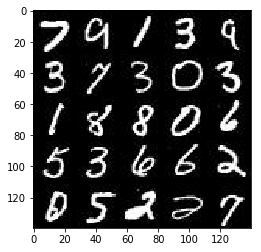

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

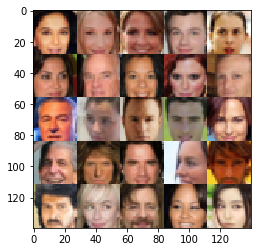

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)

        flat = tf.reshape(x3, [-1, 4*4*256])
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train) as scope:
        x = tf.layers.dense(z, 7*7*256)

        x1 = tf.reshape(x, [-1, 7, 7, 256])
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')

        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * 0.9)
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake))
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake))
    )

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_ops, g_train_ops


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    tf.reset_default_graph()
    
    input_real, input_z, learning_rate_placeholder = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               learning_rate_placeholder: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               learning_rate_placeholder: learning_rate})
                 
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 1.4208
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.4740
Epoch 1/1... Discriminator Loss: 2.4696... Generator Loss: 5.8868
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 0.5930... Generator Loss: 1.9164
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 1.3242
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 0.8967


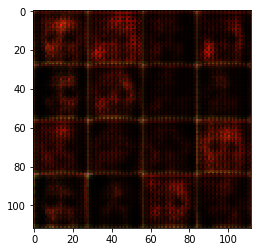

Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 3.3135
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 1.2646
Epoch 1/1... Discriminator Loss: 5.1134... Generator Loss: 4.7535
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.5124
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.9798


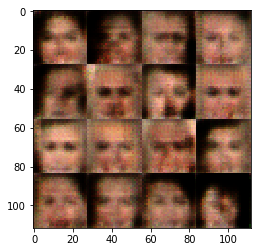

Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 1.0217
Epoch 1/1... Discriminator Loss: 1.7996... Generator Loss: 0.3095
Epoch 1/1... Discriminator Loss: 1.6047... Generator Loss: 0.4518
Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 0.3964
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.5671... Generator Loss: 0.3801
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 1.0585
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.6861


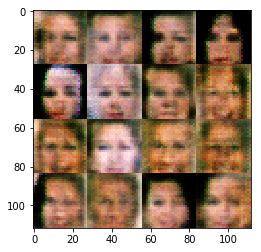

Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 1.0107
Epoch 1/1... Discriminator Loss: 1.5594... Generator Loss: 0.4672
Epoch 1/1... Discriminator Loss: 2.2199... Generator Loss: 1.8831
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.5182
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 1.4903


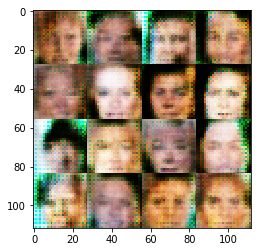

Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.6477... Generator Loss: 1.1843
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.4602
Epoch 1/1... Discriminator Loss: 1.9321... Generator Loss: 0.2935
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 1.4108
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 1.0455


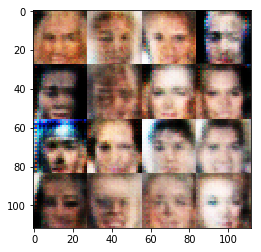

Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 1.0831
Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 0.5690
Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.5889


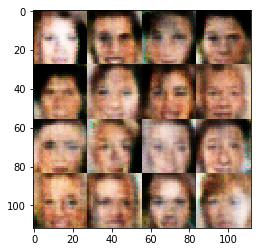

Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.7476


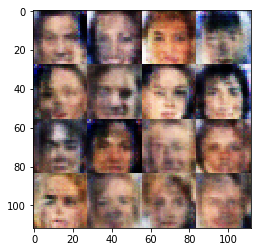

Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.5220... Generator Loss: 1.1458
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.9333
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.7887


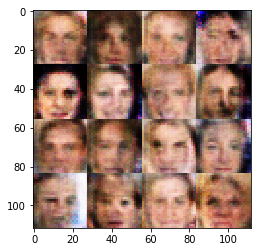

Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 1.1444
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.5005
Epoch 1/1... Discriminator Loss: 1.5216... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.8759


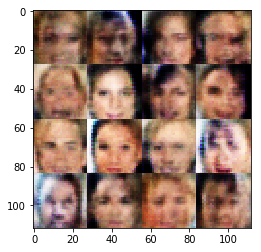

Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 1.0430
Epoch 1/1... Discriminator Loss: 1.5528... Generator Loss: 0.8755
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 1.1568
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.6876


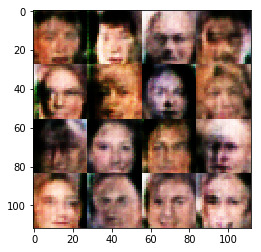

Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.6181... Generator Loss: 0.4017
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.7949


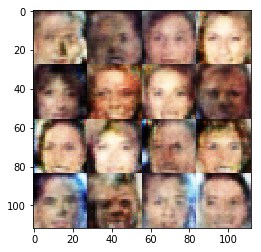

Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 1.0910
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 1.1156
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 0.4637
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.8842


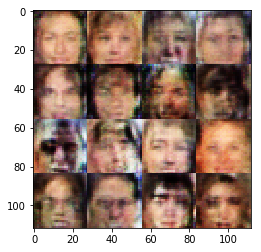

Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 1.0607
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.7606


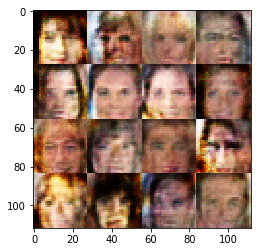

Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.6257


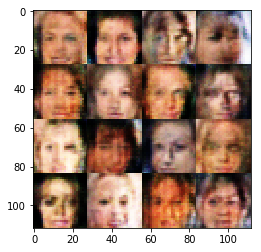

Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.5355
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.5685


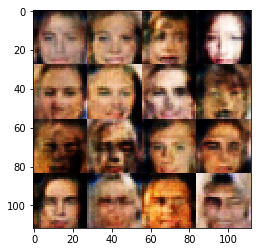

Epoch 1/1... Discriminator Loss: 1.5098... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.5967... Generator Loss: 1.2398
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 1.0830
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.8891


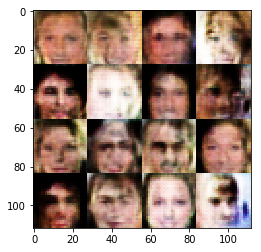

Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 1.1056
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.9156


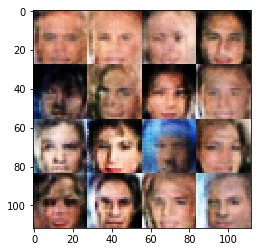

Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.9460


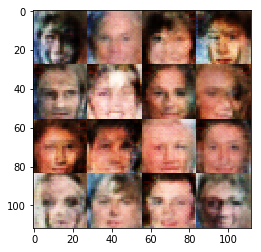

Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6929


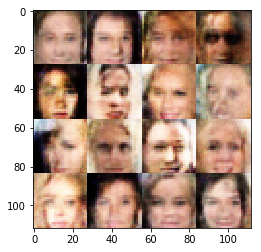

Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 1.0300
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 1.0360
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.6488


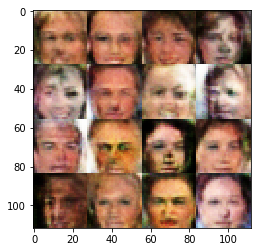

Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.8903


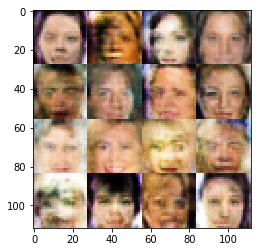

Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.5776


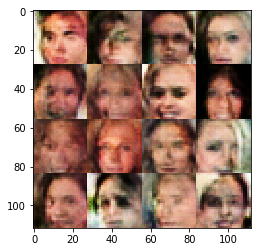

Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.7672


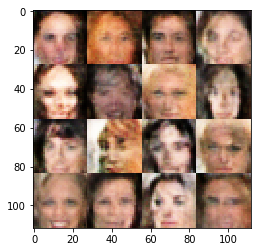

Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.6347... Generator Loss: 0.3704
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.9770


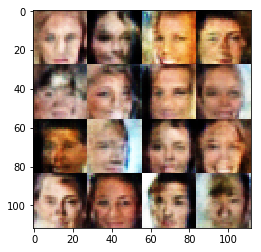

Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.9660


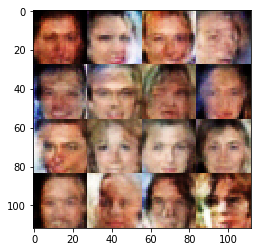

Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 1.0164
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.9077


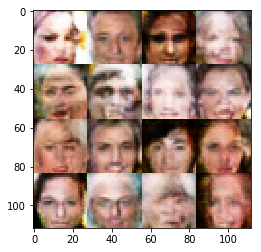

Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 1.0768
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.5274... Generator Loss: 0.4317
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.7191


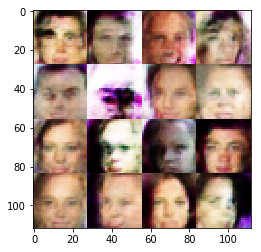

Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 1.1515


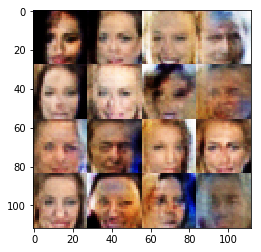

Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 1.0157
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7987


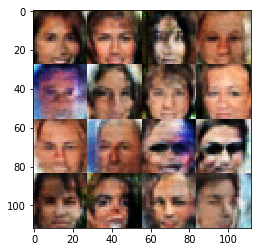

Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.5033
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.6916


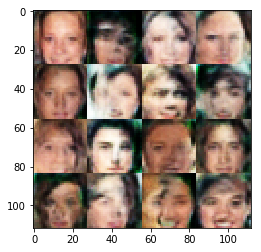

Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.6309... Generator Loss: 1.3331
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.8045


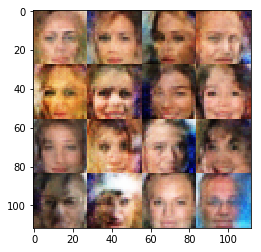

Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.8344


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.